# Data quality analysis

In [1]:
import pandas as pd
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns

### Understanding the fields in the yellow taxi data

The important fields

- `tpep_pickup_datetime`: Date time when meter was turned on
- `tpep_dropoff_datetime`: Date time when meter was turned off
- `passenger_count`: number of passengers
- `trip_distance`: distance in miles captured by the meter
- `payment_type`:
  - 1: credit card
  - 2: cash
  - 3: no charge
  - 4: dispute
  - 5: unknown
  - 6: voided trip
- `total_amount`: the total fare charged to customeers

A `total_seconds` column is probably appropiate here to do regressions on later.

### How do the fields change in the data?

The data spans a large amount of time - do the column names/fields change?

In [62]:
date_ptr = '2009-01'
fields = {}
data_path = '../data/monthly_data/yellow_taxi'

while date_ptr != '2024-01':
    try:
        data_frame = pd.read_parquet(f'{data_path}_{date_ptr}.parquet')
        fields[date_ptr] = data_frame.columns.tolist()
        date_ptr = (pd.to_datetime(date_ptr) + pd.DateOffset(months=1)).strftime('%Y-%m')
    except Exception as e:
        date_ptr = (pd.to_datetime(date_ptr) + pd.DateOffset(months=1)).strftime('%Y-%m')
        print(e)

KeyboardInterrupt: 

In [23]:
fields_str_list = []

for x in fields.values():
    fields_str_list.append(str(x))

set(fields_str_list)

{"['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'Airport_fee']",
 "['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'airport_fee']",
 "['vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count', 'trip_distance', 'pickup_longitude', 'pickup_latitude', 'rate_code', 'store_and_fwd_flag', 'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount', 'surcharge', 'mta_tax', 'tip_amount', 'tolls_amount', 'total_amount']",
 "['vendor_name', 'Trip_Picku

So there are four diffferent sets of fields. It appears the capitalised fields come from 2009. We can change these fields on the fly for data that doesn't comply. 

We also have different fields for `vendor_id`. We miss pickup and dropoff longitude and latitude for some of these months. We've found a way to find locations from the pickup location and saved it to the metadata dataframe, so this is fine. 

We at the very least wish to change the quantitative fields into the same column names for later.

In [38]:
unique_fields = [eval(s) for s in list(set(fields_str_list))]

In [42]:
ideal_fields = unique_fields[2]

In [ ]:
ideal_dict = {x: x for x in ideal_fields}
ideal_dict['tpep_pickup_datetime'] = 'pickup_datetime'
ideal_dict['tpep_dropoff_datetime'] = 'dropoff_datetime'
ideal_dict['Passenger_Count'] = 'passenger_count'
ideal_dict['Payment_Type'] = 'payment_type'
ideal_dict['Trip_Distance'] = 'trip_distance'
ideal_dict['Start_Lon'] = 'pickup_longitude'
ideal_dict['Start_Lat'] = 'pickup_latitude'
ideal_dict['End_Lon'] = 'dropoff_longitude'
ideal_dict['End_Lat'] = 'dropoff_latitude'
ideal_dict['Fare_Amt'] = 'fare_amount'
ideal_dict['Total_Amt'] = 'total_amount'
ideal_dict['Tip_Amt'] = 'tip_amount'
ideal_dict['Tolls_Amt'] = 'tolls_amount'
ideal_dict['Trip_Pickup_DateTime'] = 'pickup_datetime'
ideal_dict['Trip_Dropoff_DateTime'] = 'dropoff_datetime'

Now let's rename all of our dataframe columns and resave it onto disk.

In [58]:
date_ptr = '2009-01'
fields = {}
data_path = '../data/monthly_data/yellow_taxi'

while date_ptr != '2024-01':
    try:
        curr_path = f'{data_path}_{date_ptr}.parquet'
        data_frame = pd.read_parquet(curr_path)
        data_frame = data_frame.rename(columns=ideal_dict)
        data_frame.to_parquet(curr_path)
        date_ptr = (pd.to_datetime(date_ptr) + pd.DateOffset(months=1)).strftime('%Y-%m')
    except Exception as e:
        date_ptr = (pd.to_datetime(date_ptr) + pd.DateOffset(months=1)).strftime('%Y-%m')
        print(e)

### Outlier data for quantitative data

In [2]:
yellow_taxi_2021_01 = pd.read_parquet('../data/monthly_data/yellow_taxi_2021-01.parquet')

In [3]:
quantitative_fields = ['passenger_count', 'trip_distance', 'fare_amount', 'tip_amount', 'tolls_amount', 'total_amount']

yellow_taxi_2021_01['passenger_count'] = yellow_taxi_2021_01['passenger_count'].astype(float)

In [4]:
def detect_outliers(df, columns, threshold=10):
    df_copy = df.copy()
    zscore_columns = {col: f"{col}_zscore" for col in columns}
    for col in columns:
        df_copy[zscore_columns[col]] = zscore(df_copy[col], nan_policy='omit')  # Compute z-score
    outlier_mask = df_copy[[f"{col}_zscore" for col in columns]].abs().gt(threshold).any(axis=1)
    return df_copy[outlier_mask]

In [5]:
detect_outliers(yellow_taxi_2021_01, quantitative_fields, 2)[quantitative_fields]

,passenger_count,trip_distance,fare_amount,tip_amount,tolls_amount,total_amount
2,1.0,14.70,42.00,8.65,0.00,51.95
12,2.0,7.40,24.50,0.00,6.12,33.92
13,5.0,1.70,8.00,2.36,0.00,14.16
14,5.0,0.81,4.50,0.00,0.00,8.30
23,0.0,3.60,17.00,10.00,0.00,30.80
...,...,...,...,...,...,...
1369758,NaN,9.19,43.20,0.00,0.00,46.50
1369760,NaN,13.50,44.62,0.00,0.00,48.17
1369764,NaN,8.89,27.78,7.46,0.00,38.54
1369765,NaN,7.43,32.58,0.00,6.12,39.50


Looking at the `2` threshold outliers, we see nothing too obvious. We do however see `NaN` passenger counts. Passenger counts will be a fundamental part of our analysis later, as standardising fare amounts/tip amounts to per-passenger can give a more holistic view of the data. 

> `NaN` values seen in passenger count

In [6]:
yellow_taxi_outliers = detect_outliers(yellow_taxi_2021_01, quantitative_fields, 5)[quantitative_fields].copy()

Moving into the `5` threshold outliers, most of these are tip amounts. Of course large tips are outlier events, and trying to actually predict large tips is likely difficult as many factors can come into play. Whether we decide to filter large tips out to improve our regression will be decide upon later.

Let's take a sorted look at each of these outliers.

In [7]:
yellow_taxi_outliers.sort_values(quantitative_fields)

,passenger_count,trip_distance,fare_amount,tip_amount,tolls_amount,total_amount
877147,0.0,0.00,2.50,20.00,0.0,24.30
2054,0.0,0.00,2.50,40.00,0.0,43.80
1169346,0.0,0.00,2.50,75.00,0.0,78.30
930724,0.0,0.00,2.50,100.00,0.0,105.80
1055756,0.0,0.00,2.50,100.00,0.0,105.80
...,...,...,...,...,...,...
1301103,NaN,85947.42,10.95,2.75,0.0,14.50
1360247,NaN,87507.93,22.19,0.00,0.0,25.74
1308996,NaN,112257.10,14.11,2.75,0.0,17.66
1358841,NaN,140549.58,12.12,0.00,0.0,15.67


We see some pretty unusual values for trip distance. We see zero trip distance trips that have fare amounts and tip amounts, and we also have very large trip distances for small total amounts.

We can see that these large trip distances have null passenger counts. What happens if we get rid of them?

### `NaN`'s in data

In [8]:
no_nans = yellow_taxi_outliers.dropna(subset=quantitative_fields).sort_values('trip_distance')
no_nans

,passenger_count,trip_distance,fare_amount,tip_amount,tolls_amount,total_amount
1271410,1.0,0.0,200.0,10.00,0.00,210.30
376546,1.0,0.0,36.2,0.00,12.24,49.24
877152,1.0,0.0,36.2,0.00,12.24,49.24
877147,0.0,0.0,2.5,20.00,0.00,24.30
875237,2.0,0.0,7.5,0.00,12.24,20.54
...,...,...,...,...,...,...
993808,1.0,270.2,688.5,0.00,23.50,715.30
166458,1.0,271.4,808.5,0.00,60.74,872.54
427817,0.0,326.1,879.0,192.61,80.74,1155.65
764804,1.0,427.7,1128.5,1140.44,20.16,2292.40


This seems to have basically solved everything. 

Let's make the following adjustments:
1. No passenger counts of zero - we can't make any inferences on a standardised per-passenger basis
2. No `NaN` passenger counts - same as above. Passengers <= 5; NYC biggest taxi is a minivan.
3. No trip distances of zero. Trip distances of atleast 0.1 miles.
4. We want to only consider local trips - that is, New York City is, at widest, 35 miles wide. The trip distance is already in miles, so we can just filter on trip distances < 35.

### Zeroes

In [9]:
no_nans_no_zeroes_in_ny = no_nans[
    (no_nans['trip_distance'] != 0) &
    (no_nans['trip_distance'] < 35) &
    (no_nans['trip_distance'] >= 0.1) &
    (no_nans['passenger_count'] <= 5)
]
no_nans_no_zeroes_in_ny

,passenger_count,trip_distance,fare_amount,tip_amount,tolls_amount,total_amount
111947,2.0,0.10,96.0,0.00,0.00,96.30
662583,1.0,0.10,2.5,26.70,0.00,30.00
1237221,1.0,0.10,78.0,15.76,0.00,94.56
248332,1.0,0.10,80.0,0.00,0.00,80.30
209959,1.0,0.10,60.0,0.00,811.75,872.05
...,...,...,...,...,...,...
548892,1.0,34.90,164.0,15.00,23.87,203.17
43723,1.0,34.92,131.5,20.76,6.12,159.18
996715,1.0,34.92,125.0,0.00,0.00,125.30
846029,1.0,34.93,102.0,0.00,17.87,121.17


Clearly there are some problems here, but we'll deal with these in later sections.

### Non-sensical negative values

In [10]:
for field in quantitative_fields:
    num_of_negative = len(yellow_taxi_2021_01[quantitative_fields][yellow_taxi_2021_01[field] < 0].dropna())
    print(f'Field: {field}\t| Negative values: {num_of_negative}')

Field: passenger_count	| Negative values: 0
Field: trip_distance	| Negative values: 0
Field: fare_amount	| Negative values: 6655
Field: tip_amount	| Negative values: 56
Field: tolls_amount	| Negative values: 139
Field: total_amount	| Negative values: 6654


Clearly there are some issues here. 

https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/discussion/62293

The discussion here on Kaggle states that these are likely refunds. We can probably safely drop these. For tip and tolls amount, these are such a small part of the data that I think it's not really worth mentioning, but we'll still get rid of these.

In [11]:
filtered_in_ny = no_nans_no_zeroes_in_ny[
    (no_nans_no_zeroes_in_ny[quantitative_fields] > 0).all(axis=1)
]
filtered_in_ny

,passenger_count,trip_distance,fare_amount,tip_amount,tolls_amount,total_amount
552485,1.0,0.16,143.0,4.00,6.12,153.92
794812,2.0,0.18,52.0,15.35,6.12,76.77
1196766,2.0,0.20,52.0,19.00,6.12,82.42
445764,1.0,0.20,110.0,23.25,6.12,139.67
910980,1.0,0.20,52.0,17.65,6.12,76.57
...,...,...,...,...,...,...
164365,1.0,34.86,90.5,2.75,18.20,112.75
918771,1.0,34.87,150.0,20.00,17.87,188.17
11559,1.0,34.88,91.0,2.75,6.12,100.67
548892,1.0,34.90,164.0,15.00,23.87,203.17


### Duplicated data

Another key concern for the data is if there are duplicate vendors that are reporting the same trip.

This can happen in many data sources - as different vendors can all report the same data.

In [89]:
yellow_taxi_2021_01.duplicated().sum()

0

We see there are no duplicated rows at all. A possible concern is trip start and trip end times are different due to jitter/data retrieval differences - but since the data is in second precision, we are not too concerned about this.

### Non-sensical trip times

We now check for trip times that are far too long (or even negative!)

In [13]:
yellow_taxi_2021_01['dropoff_datetime'] = pd.to_datetime(yellow_taxi_2021_01['dropoff_datetime'])
yellow_taxi_2021_01['pickup_datetime'] = pd.to_datetime(yellow_taxi_2021_01['pickup_datetime'])

In [14]:
yellow_taxi_2021_01[yellow_taxi_2021_01['dropoff_datetime'] < yellow_taxi_2021_01['pickup_datetime']]

,VendorID,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
151936,1,2021-01-05 17:43:19,2021-01-05 17:39:06,1.0,0.00,1.0,N,145,145,2,4.00,1.0,0.5,0.0,0.0,0.3,5.80,0.0,NaN
556110,1,2021-01-15 07:27:40,2020-10-13 12:03:02,1.0,1.60,1.0,N,161,234,1,9.00,2.5,0.5,1.0,0.0,0.3,13.30,2.5,NaN
1271424,6,2021-01-01 00:01:06,2021-01-01 00:01:02,NaN,9.23,NaN,None,265,108,0,33.73,0.0,0.5,0.0,0.0,0.3,34.53,NaN,NaN
1271441,6,2021-01-01 00:01:14,2021-01-01 00:01:02,NaN,4.10,NaN,None,265,69,0,16.52,0.0,0.5,0.0,0.0,0.3,17.32,NaN,NaN
1271464,6,2021-01-01 00:01:08,2021-01-01 00:01:03,NaN,11.23,NaN,None,265,35,0,31.45,0.0,0.5,0.0,0.0,0.3,32.25,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1369730,6,2021-01-31 22:01:22,2021-01-31 22:01:03,NaN,2.63,NaN,None,265,136,0,35.20,0.0,0.5,0.0,0.0,0.3,36.00,NaN,NaN
1369741,6,2021-01-31 23:01:55,2021-01-31 23:01:02,NaN,16.09,NaN,None,265,3,0,42.55,0.0,0.5,0.0,0.0,0.3,43.35,NaN,NaN
1369742,6,2021-01-31 23:01:05,2021-01-31 23:01:02,NaN,11.11,NaN,None,265,117,0,37.28,0.0,0.5,0.0,0.0,0.3,38.08,NaN,NaN
1369746,6,2021-01-31 23:01:39,2021-01-31 23:01:02,NaN,6.92,NaN,None,265,188,0,21.74,0.0,0.5,0.0,0.0,0.3,22.54,NaN,NaN


There are ~5642 trips where the drop off tiem is before the pickup time. What about extremely long trips?

In [15]:
yellow_taxi_2021_01['trip_time_in_mins'] = (yellow_taxi_2021_01['dropoff_datetime'] - yellow_taxi_2021_01['pickup_datetime']).dt.total_seconds() / 60

In [19]:
yellow_taxi_2021_01.sort_values('trip_time_in_mins')[['pickup_datetime', 'dropoff_datetime', 'trip_time_in_mins']]

,pickup_datetime,dropoff_datetime,trip_time_in_mins
556110,2021-01-15 07:27:40,2020-10-13 12:03:02,-135084.633333
151936,2021-01-05 17:43:19,2021-01-05 17:39:06,-4.216667
1280740,2021-01-05 00:01:59,2021-01-05 00:01:01,-0.966667
1344161,2021-01-23 18:01:59,2021-01-23 18:01:01,-0.966667
1345467,2021-01-24 13:01:59,2021-01-24 13:01:02,-0.950000
...,...,...,...
1312451,2021-01-13 23:01:03,2021-01-15 03:01:12,1680.150000
750656,2021-01-20 00:18:37,2021-01-21 08:38:04,1939.450000
591784,2021-01-15 18:35:33,2021-01-17 06:29:09,2153.600000
344036,2021-01-10 10:56:18,2021-01-13 12:35:25,4419.116667


A trip of 4419 minutes is 3 days. Obviously this doesn't make much sense for a yellow taxi ride. We apply a `z`-score filter of 2 on trip times.

In [40]:
import numpy as np

def adjusted_zscore(series):
    median = np.median(series)
    mad = np.median(np.abs(series - median))  # Median Absolute Deviation
    return 0.6745 * (series - median) / mad

yellow_taxi_2021_01['trip_time_z_score'] = adjusted_zscore(yellow_taxi_2021_01['trip_time_in_mins'])
no_trip_outliers = yellow_taxi_2021_01[abs(yellow_taxi_2021_01['trip_time_z_score']) < 2]

In [42]:
no_trip_outliers['trip_time_in_mins'].sort_values()

1280740    -0.966667
1344161    -0.966667
1299193    -0.950000
1333176    -0.950000
1365462    -0.950000
             ...    
814842     21.266667
658312     21.266667
1274887    21.266667
1293278    21.266667
440412     21.266667
Name: trip_time_in_mins, Length: 1209592, dtype: float64

In [43]:
x = no_trip_outliers[(no_trip_outliers['fare_amount'] < 100) & (no_trip_outliers['fare_amount'] > 0)]

We still there still exists some non-linearity which may be explained by many different factors, but we'll deal with this during our analysis.

### Distribution analysis

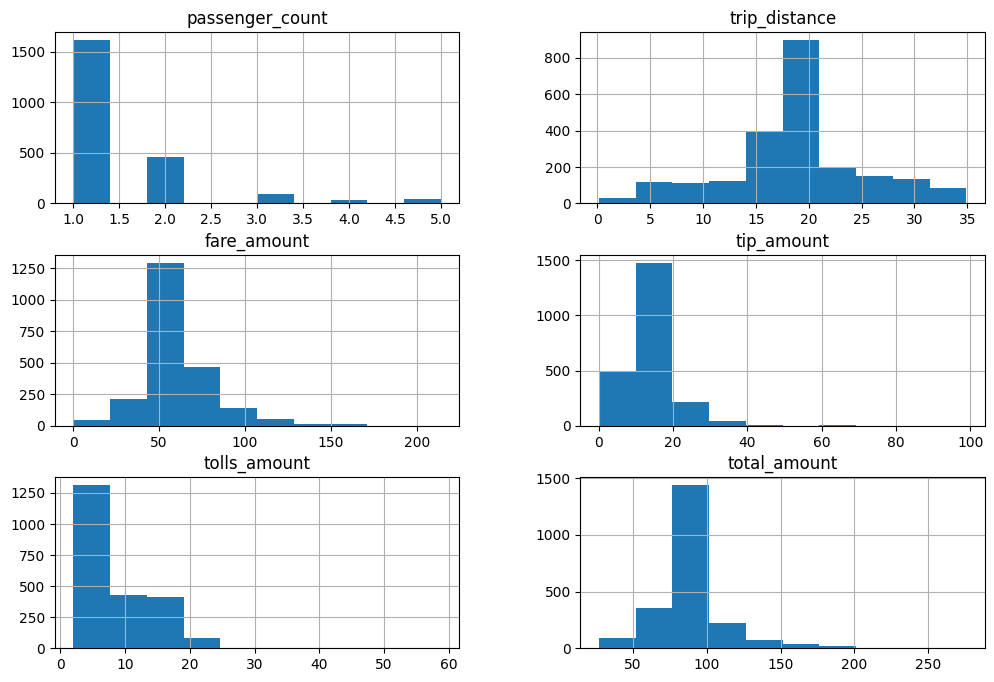

In [90]:
filtered_in_ny.hist(figsize=(12, 8));

Nothing obviously wrong here.

### Correlation analysis

In [91]:
filtered_in_ny.corr()

,passenger_count,trip_distance,fare_amount,tip_amount,tolls_amount,total_amount
passenger_count,1.000000,0.032562,0.017524,-0.007289,0.005437,0.014117
trip_distance,0.032562,1.000000,0.696575,0.015007,-0.068757,0.611275
fare_amount,0.017524,0.696575,1.000000,0.058270,0.203756,0.938029
tip_amount,-0.007289,0.015007,0.058270,1.000000,-0.233301,0.350033
tolls_amount,0.005437,-0.068757,0.203756,-0.233301,1.000000,0.276334
total_amount,0.014117,0.611275,0.938029,0.350033,0.276334,1.000000


Clearly strong correlations with trip distance and fare amount - the residuals of this regression should be derived from surge pricing, and different pricing rules for different zones

<Axes: xlabel='trip_distance', ylabel='fare_amount'>

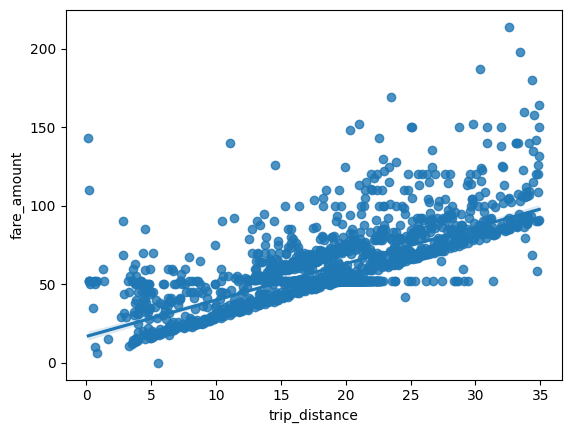

In [92]:
sns.regplot(filtered_in_ny, x='trip_distance', y='fare_amount')

Clearly there is a minimum fare trip rate which can be expressed by the bounded linear relationship that can be seen.

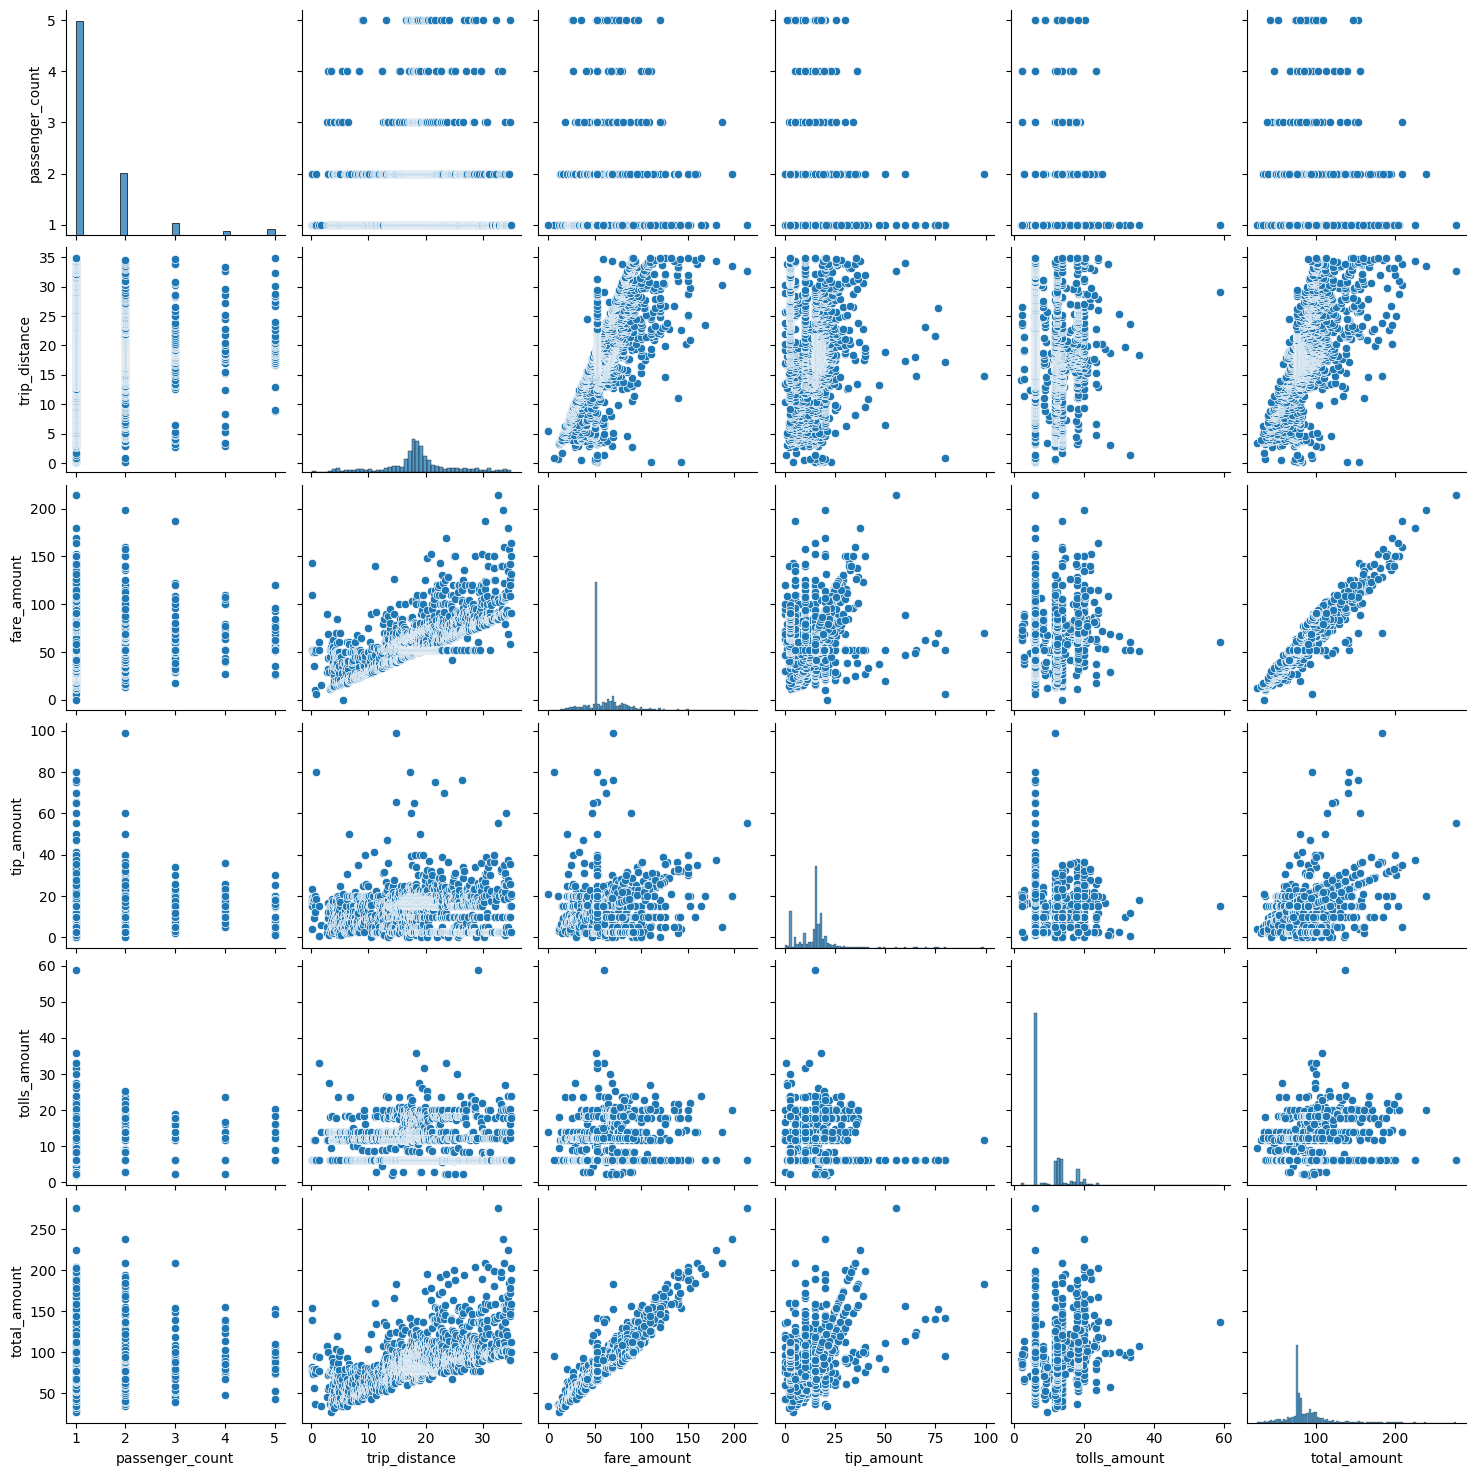

In [93]:
sns.pairplot(filtered_in_ny)

There appears to be multiple fare amounts that are at $50. I theorise these are fixed rate trips ("I'll pay you $50 for this trip"). To check how many of these there are:

In [98]:
filtered_in_ny[filtered_in_ny['fare_amount'] == 50]

,passenger_count,trip_distance,fare_amount,tip_amount,tolls_amount,total_amount,fare_amount/trip_distance
840010,1.0,0.30,50.0,16.90,6.12,73.32,166.666667
144459,1.0,0.70,50.0,12.40,11.75,74.45,71.428571
1197981,1.0,3.77,50.0,13.31,13.75,79.86,13.262599
671565,1.0,3.86,50.0,16.64,13.75,83.19,12.953368
1101489,1.0,4.12,50.0,10.00,11.75,74.55,12.135922
843863,1.0,4.37,50.0,5.55,11.75,70.60,11.441648
998504,1.0,4.59,50.0,6.00,13.75,72.55,10.893246
840593,1.0,4.60,50.0,13.41,13.75,80.46,10.869565
45788,1.0,4.67,50.0,19.96,13.75,86.51,10.706638
1091631,1.0,4.84,50.0,1.00,13.75,67.55,10.330579


Not really enough for me to be overly concerned about.

With the above information, we create the data cleaning class.

**We'll do more of this analysis in another notebook.**